In [1]:
# Datos
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# `cleaned_reviews.csv`

## Análisis Exploratorio

### Carga de datos

In [2]:
df_cleaned_reviews = pd.read_csv('dataset/cleaned_reviews.csv')

### Revisión de datos

Comprueba la estructura de los datos, como la cantidad de filas y columnas, los tipos de datos de cada columna, y si hay datos faltantes o valores atípicos.

In [3]:
df_cleaned_reviews.head()

,Unnamed: 0,reviews,rates,date,country,verified,comments
0,0,✅ Trip Verified | Excellent service both on th...,5,2023-01-24,United Kingdom,True,excellent service ground board first class pro...
1,1,✅ Trip Verified | Good lounge at Cape Town. O...,9,2023-01-24,United Kingdom,True,good lounge cape town time departure drink hig...
2,2,✅ Trip Verified | A really excellent journey....,9,2023-01-23,United Kingdom,True,really excellent journey lounge overcrowded la...
3,3,✅ Trip Verified | This flight was one of the ...,9,2023-01-21,United Kingdom,True,flight one worst ever life wanted pamper bough...
4,4,Not Verified | It seems that there is a race t...,2,2023-01-19,United States,False,verified seems race bottom amongst airline can...


In [4]:
# Cantidad de filas y columnas
print(df_cleaned_reviews.shape)

(3411, 7)


In [5]:
df_cleaned_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3411 entries, 0 to 3410
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3411 non-null   int64 
 1   reviews     3411 non-null   object
 2   rates       3411 non-null   int64 
 3   date        3411 non-null   object
 4   country     3411 non-null   object
 5   verified    3411 non-null   bool  
 6   comments    3411 non-null   object
dtypes: bool(1), int64(2), object(4)
memory usage: 163.3+ KB


valores nulos

In [6]:
df_cleaned_reviews.isnull().sum()

Unnamed: 0    0
reviews       0
rates         0
date          0
country       0
verified      0
comments      0
dtype: int64

Evaluamos que features son categoricas

In [7]:
df_cleaned_reviews["country"].value_counts()

country
United Kingdom           2165
United States             361
Australia                 147
Canada                    104
Germany                    60
                         ... 
Iceland                     1
Saint Kitts and Nevis       1
Costa Rica                  1
Cayman Islands              1
Oman                        1
Name: count, Length: 69, dtype: int64

In [8]:
df_cleaned_reviews["verified"].value_counts()

verified
False    2435
True      976
Name: count, dtype: int64

In [9]:
df_cleaned_reviews["verified"].value_counts()

verified
False    2435
True      976
Name: count, dtype: int64

### Limpieza de datos

Limpia los datos tratando con valores faltantes, valores atípicos, duplicados, y cualquier otro problema que pueda afectar la calidad de los datos y los análisis posteriores.

In [10]:
# Eliminamos la columna "Unnamed: 0"
df_cleaned_reviews = df_cleaned_reviews.drop(columns=['Unnamed: 0'])

# Convertir la columna "date" a tipo datetime
df_cleaned_reviews['date'] = pd.to_datetime(df_cleaned_reviews['date'])

# Eliminar filas duplicados.
df_cleaned_reviews.drop_duplicates(inplace=True)

# La columna "country" es una variable categórica, por lo que la convertimos a tipo "category"
df_cleaned_reviews['country'] = df_cleaned_reviews['country'].astype('category')

### Resumen estadístico

Calcula estadísticas descriptivas como la media, la mediana, la desviación estándar, los percentiles, etc., para comprender mejor la distribución y la variabilidad de los datos.

In [11]:
df_cleaned_reviews.describe()

,rates,date
count,3410.000000,3410
mean,4.819941,2017-05-18 07:24:14.780058624
min,1.000000,2014-05-18 00:00:00
25%,2.000000,2015-08-15 00:00:00
50%,4.000000,2016-12-08 12:00:00
75%,8.000000,2018-09-15 18:00:00
max,10.000000,2023-01-24 00:00:00
std,3.145510,NaN


## Graficos

### Cantidad de comentarios por país

In [12]:
cantidad = df_cleaned_reviews.rates.value_counts().sort_index()

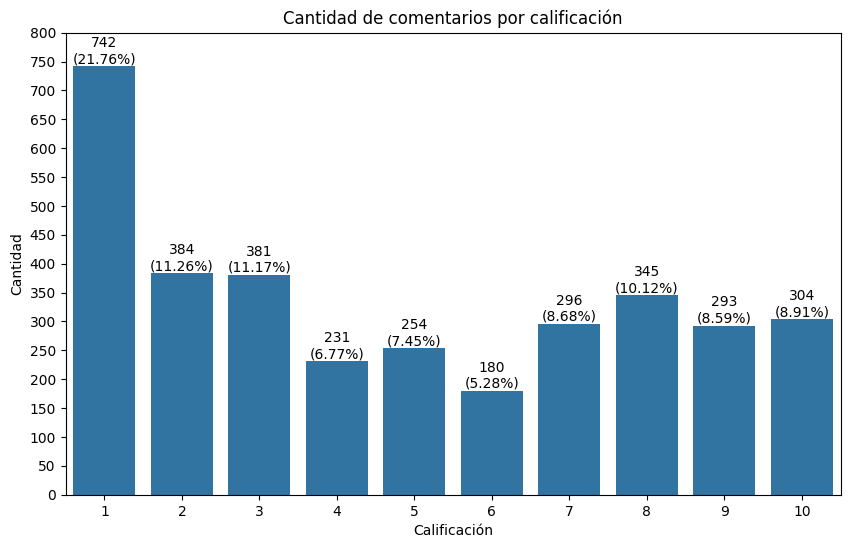

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x=cantidad.index, y=cantidad.values)
plt.title('Cantidad de comentarios por calificación')
plt.xlabel('Calificación')
plt.ylabel('Cantidad')

for i in range(cantidad.shape[0]):
    plt.text(i, cantidad.values[i], f'{cantidad.values[i]}\n({cantidad.values[i]/cantidad.sum()*100:.2f}%)', ha='center', va='bottom')

plt.yticks(range(0, 850, 50))

plt.show()

### ¿Qué paises hicieron mas reviews?

In [14]:
number_of_reviews_per_country = df_cleaned_reviews.groupby(["country"])["reviews"].count()

C:\Users\lufer\AppData\Local\Temp\ipykernel_25640\1981308916.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  number_of_reviews_per_country = df_cleaned_reviews.groupby(["country"])["reviews"].count()


In [15]:
group = df_cleaned_reviews.groupby(["verified", "country"])["reviews"].count()
number_reviews_per_country_true = group.loc[True]  
number_reviews_per_country_false = group.loc[False]  

C:\Users\lufer\AppData\Local\Temp\ipykernel_25640\928160679.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df_cleaned_reviews.groupby(["verified", "country"])["reviews"].count()


In [16]:
five_more_reviews_true = number_reviews_per_country_true.nlargest()
five_more_reviews_true["Others"] = number_reviews_per_country_true.sum() - five_more_reviews_true.sum()
five_more_reviews_true

country
United Kingdom    558
United States     137
Australia          30
Canada             28
Germany            28
Others            195
Name: reviews, dtype: int64

In [17]:
five_more_reviews_false = number_reviews_per_country_false.nlargest()
five_more_reviews_false["Others"] = number_reviews_per_country_false.sum() - five_more_reviews_false.sum()
five_more_reviews_false

country
United Kingdom    1606
United States      224
Australia          117
Canada              76
Germany             32
Others             379
Name: reviews, dtype: int64

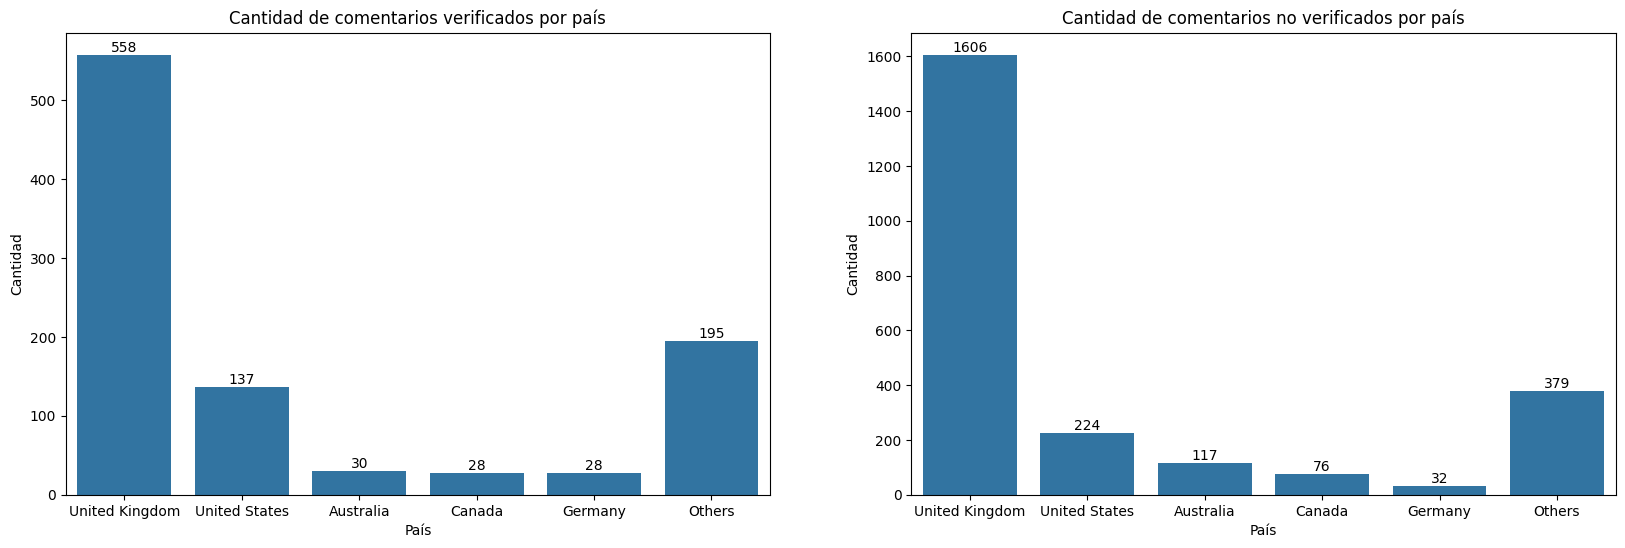

In [18]:
# barplot verified = True and verified = False
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.barplot(x=five_more_reviews_true.index, y=five_more_reviews_true.values, ax=axes[0])

axes[0].set_title('Cantidad de comentarios verificados por país')
axes[0].set_xlabel('País')
axes[0].set_ylabel('Cantidad')

for i in range(five_more_reviews_true.shape[0]):
    axes[0].text(i, five_more_reviews_true.values[i], f'{five_more_reviews_true.values[i]}', ha='center', va='bottom')

sns.barplot(x=five_more_reviews_false.index, y=five_more_reviews_false.values, ax=axes[1])

axes[1].set_title('Cantidad de comentarios no verificados por país')
axes[1].set_xlabel('País')
axes[1].set_ylabel('Cantidad')

for i in range(five_more_reviews_false.shape[0]):
    axes[1].text(i, five_more_reviews_false.values[i], f'{five_more_reviews_false.values[i]}', ha='center', va='bottom')

plt.show()

Grafico de barras apiladas

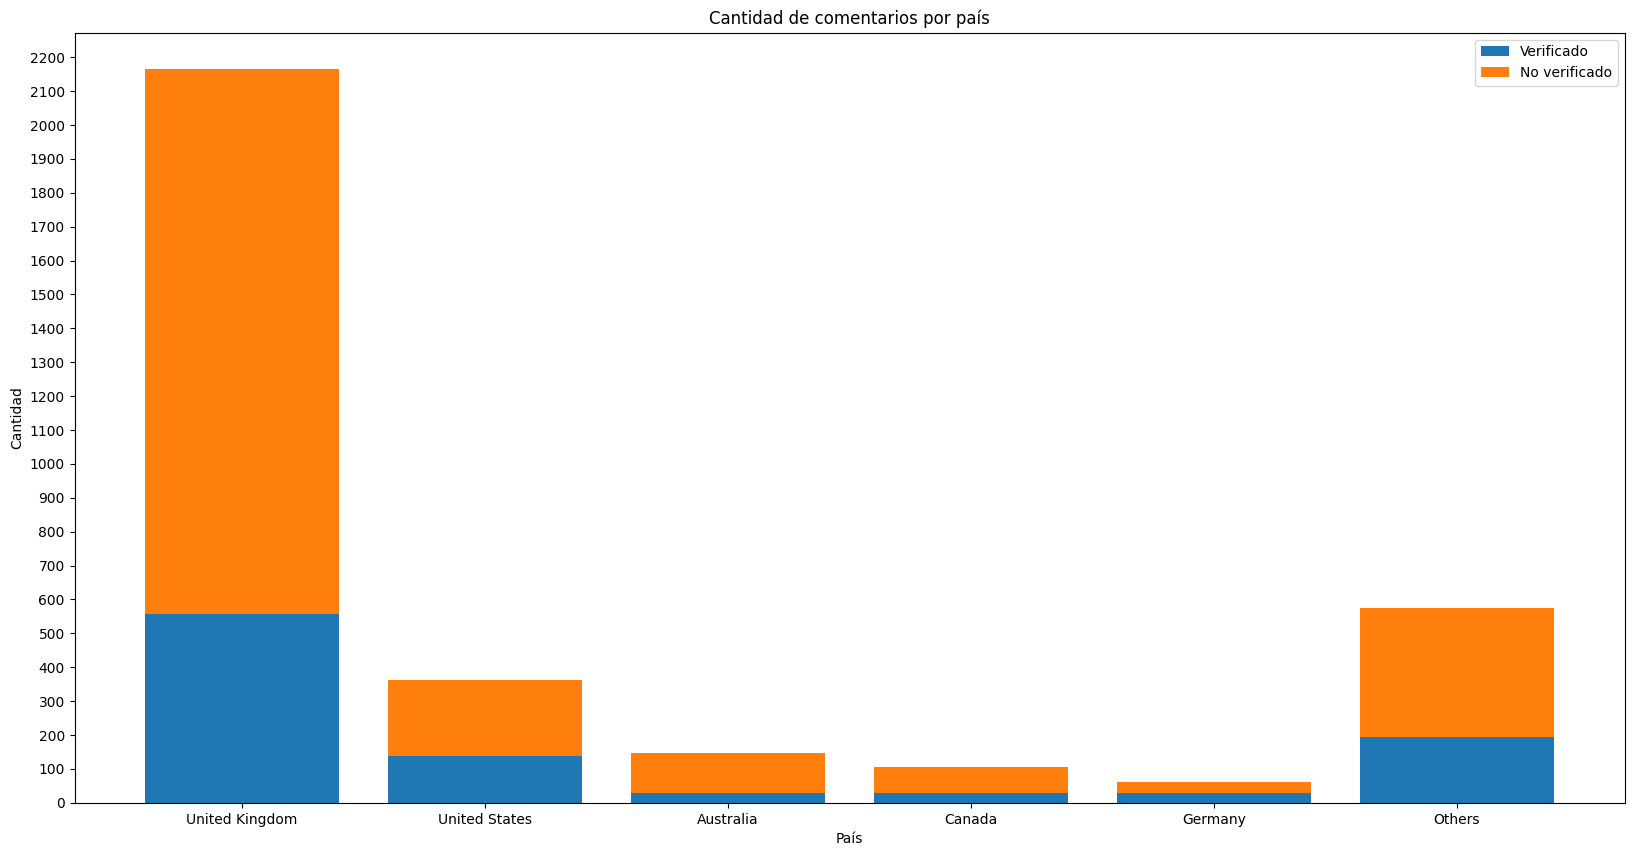

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(five_more_reviews_true.index, five_more_reviews_true.values, label='Verificado')
ax.bar(five_more_reviews_false.index, five_more_reviews_false.values, bottom=five_more_reviews_true.values, label='No verificado')

ax.set_title('Cantidad de comentarios por país')
ax.set_xlabel('País')
ax.set_ylabel('Cantidad')

ax.set_yticks(range(0, 2300, 100))

ax.legend()

plt.show()


# `filtered_customer_booking.csv`

## Análisis Exploratorio

### Carga de datos

In [20]:
df_filtered = pd.read_csv('dataset/filtered_customer_booking.csv')

### Revisión de datos

In [21]:
df_filtered.head()

,Unnamed: 0,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [22]:
df_filtered.shape

(49982, 15)

In [23]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49982 entries, 0 to 49981
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             49982 non-null  int64  
 1   num_passengers         49982 non-null  int64  
 2   sales_channel          49982 non-null  object 
 3   trip_type              49982 non-null  object 
 4   purchase_lead          49982 non-null  int64  
 5   length_of_stay         49982 non-null  int64  
 6   flight_hour            49982 non-null  int64  
 7   flight_day             49982 non-null  int64  
 8   route                  49982 non-null  object 
 9   booking_origin         49982 non-null  object 
 10  wants_extra_baggage    49982 non-null  int64  
 11  wants_preferred_seat   49982 non-null  int64  
 12  wants_in_flight_meals  49982 non-null  int64  
 13  flight_duration        49982 non-null  float64
 14  booking_complete       49982 non-null  int64  
dtypes:

valores nulos

In [24]:
df_filtered.isnull().sum()

Unnamed: 0               0
num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

Posibles columnas categoricas

In [25]:
df_filtered["sales_channel"].value_counts()

sales_channel
Internet    44366
Mobile       5616
Name: count, dtype: int64

In [26]:
df_filtered["trip_type"].value_counts()

trip_type
RoundTrip     49479
OneWay          387
CircleTrip      116
Name: count, dtype: int64

In [27]:
df_filtered["route"].value_counts()

route
AKLKUL    2678
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: count, Length: 799, dtype: int64

In [28]:
df_filtered["booking_origin"].value_counts()

booking_origin
Australia               17865
Malaysia                 7173
South Korea              4559
Japan                    3884
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: count, Length: 104, dtype: int64

### Resumen estadistico

In [29]:
df_filtered.describe()

,Unnamed: 0,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000
mean,24999.957905,1.591133,84.754652,23.046757,9.065344,3.814253,0.668881,0.297047,0.427174,7.277333,0.149574
std,14433.587942,1.020217,89.923276,33.892624,5.412551,1.992722,0.470621,0.456962,0.494673,1.496829,0.356657
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,12500.250000,1.000000,21.000000,5.000000,5.000000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,25000.500000,1.000000,51.000000,17.000000,9.000000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,37498.750000,2.000000,115.000000,28.000000,13.000000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,49999.000000,9.000000,495.000000,778.000000,23.000000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


### limpiza de datos

In [30]:
# Eliminamos la columna "Unnamed: 0"
df_filtered = df_filtered.drop(columns=['Unnamed: 0'])

df_filtered['sales_channel'] = df_filtered['sales_channel'].astype('category')
df_filtered['trip_type'] = df_filtered['trip_type'].astype('category')
df_filtered['route'] = df_filtered['route'].astype('category')
df_filtered['booking_origin'] = df_filtered['booking_origin'].astype('category')

## Graficos

Text(0.5, 1.0, 'Distribución de la variable "purchase_lead"')

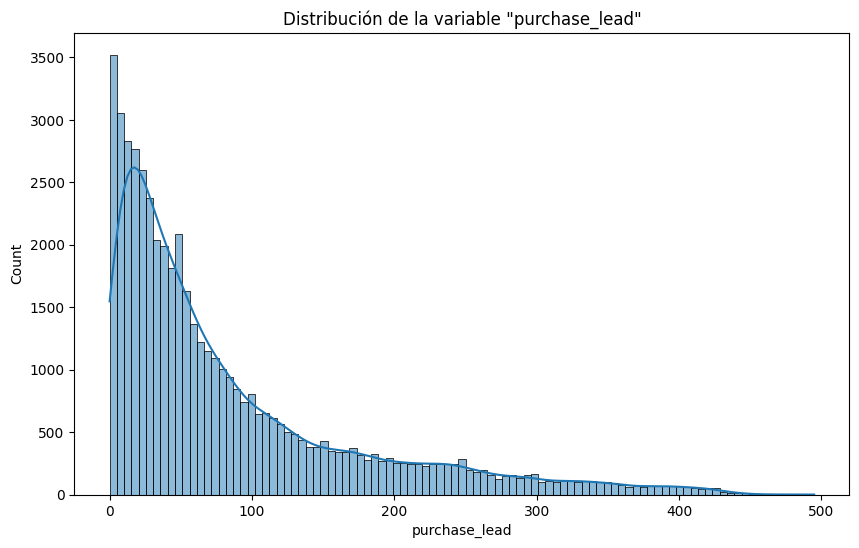

In [31]:
# Graficams la distribución 	purchase_lead
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered.purchase_lead, kde=True)
plt.title('Distribución de la variable "purchase_lead"')